In [1]:
using DrWatson
@quickactivate "Doran_etal_2022"

using Dates
using Muon
using SPI
using CSV, DataFrames
using NewickTreeTools
using CategoricalArrays: categorical
using Random: shuffle
using Statistics
using Distances
using StatsPlots
using Glob

In [15]:
pdir = plotsdir("FigS3") |> mkpath

"/Users/ben/projects/Doran_etal_2022/plots/FigS3"

In [2]:

NCUTS = 100
NPERMS = 5
TODAY = today()
taxaranklabels = [:Phylum, :Class, :Order, :Family, :Genus, :Species]
taxarankcolors = [:red :pink :orange :lightblue :green :aqua];

In [ ]:
→

In [3]:

function clusters_per_cutlevel(distfun::Function, tree::Node, ncuts::Number)
    minmax = extrema(mapinternalnodes(distfun, tree, tree))
    cuts = range(0, minmax[2], length=ncuts)
    clusts = [cuttree(distfun, tree, cut) for cut in cuts]
    clustmappings = map(c->getleafnames.(c), clusts)
    clustersmps = [vcat(clustmapping...) for clustmapping in clustmappings]
    clusterids = [Int.(vcat([zeros(length(c)) .+ j for (j, c) in enumerate(clustmapping)]...)) for clustmapping in clustmappings];
    return clusterids, clustersmps
end

function pairedMIagainstmetacolumn(metacolumns, IDS, clusterids, clustersmps; doshuffle=false)
    tstat_MI = zeros(length(clusterids), size(metacolumns, 2))
    for (i, mcol) in enumerate(eachcol(metacolumns))
        pcat = mcol .== permutedims(replace(mcol, ""=>"missing"))
        tstat_MI[:, i] .= collectMI_across_treedepth(clusterids, clustersmps, IDS, pcat; doshuffle)
    end
    DataFrame(tstat_MI, names(metacolumns)) |> stack |> df->rename!(df,["taxaID","MI"]);
end

function collectMI_across_treedepth(clusterids, clustersmps, IDS, ptax; doshuffle=false)
    uppertriangle = triu(trues(length(IDS), length(IDS)), 1);
    map(clusterids, clustersmps) do cids, smps
        clustorder = indexin(IDS,smps)
        pcids = cids[clustorder] .== cids[clustorder]'
        pcids = doshuffle ? shuffle(pcids[uppertriangle]) : pcids[uppertriangle]
        empiricalMI(ptax[uppertriangle], pcids)
    end
end

collectMI_across_treedepth (generic function with 1 method)

In [ ]:

uniprot = readh5ad(joinpath(datadir(), "exp_pro", "UP7047", "2020_02_UP7047.h5ad"))
rowmeta = CSV.read(datadir("exp_raw", "UP7047", "UProwmeta.csv"), DataFrame);
UPtaxa = rowmeta[:, [:proteomeID, :Phylum, :Class, :Order, :Family, :Genus, :Species]];
UPtaxa = coalesce.(UPtaxa, "")
UPIDS = UPtaxa.proteomeID;
# close(uniprot.file)

In [5]:
SPImtx = uniprot.obsp["SPI_distances"][:, :];

7047×7047 Matrix{Float64}:
     0.0  26239.8  33540.0  21620.2  …  35139.1  29883.5  36252.9  29259.4
 26239.8      0.0  26865.5  12531.6     28417.3  20169.5  28420.7  21810.0
 33540.0  26865.5      0.0  22203.0     36965.1  27046.9  36318.6  30924.0
 21620.2  12531.6  22203.0      0.0     23905.1  16483.8  23651.3  16696.2
 24139.3  15668.5  24682.3  10129.7     27246.3  18818.9  27622.9  20347.7
 27828.2  19885.0  29891.7  15501.7  …  31110.3  22991.5  30755.0  24320.6
 50072.6  40411.7  48897.1  37269.9     52060.4  45447.5  50819.7  45340.4
 42904.4  34243.3  40411.4  29846.3     43627.8  32120.4  42612.9  37517.1
 28591.8  19423.1  28525.7  13838.9     30099.1  22542.1  29204.9  23700.7
 30687.7  18973.9  32213.6  17848.3     33484.9  25065.4  33909.2  26981.4
     ⋮                               ⋱                        ⋮    
 34387.0  26690.8  34713.9  22823.5     37579.5  30432.7  39075.2  30765.0
 46353.9  40796.5  49203.5  37275.8     51467.2  42451.0  52889.0  45554.1
 3373

In [7]:
notclassmissing = UPtaxa[:, [:Phylum, :Class, :Order, :Family, :Genus, :Species]] |>
    df -> mapslices(x->!any(x.==""), Matrix(df), dims=2) |> vec;

In [38]:
sum(notclassmissing)

6131

In [8]:
## Caclulate MI curves for SPI tree ##
# spi_tree = readnw(read(joinpath(projectdir(), "_research", "runSPIonUP7047rows", "2020_02_UP7047-supporttree.nw"), String));
hc = hclust(SPImtx[notclassmissing, notclassmissing], linkage=:average, branchorder=:optimal)
spi_tree = readnw(SPI.nwstr(hc, String.(UPIDS[notclassmissing]); labelinternalnodes=false))
string.(UPIDS[notclassmissing]);

as_polytomy!(spi_tree, fun=n->NewickTree.support(n)<0.5)
as_polytomy!(spi_tree, fun=n->NewickTree.distance(n)<1e-8);

In [9]:

@info "calculate tree cuts for SPI tree..."
@time clusterids, clustersmps = clusters_per_cutlevel(network_distance, spi_tree, NCUTS);

@info "calculate test MI for SPI tree..."
# @time tstatdf = pairedMIagainstmetacolumn(UPtaxa[!,2:end], UPIDS, clusterids, clustersmps)
@time tstatdf = pairedMIagainstmetacolumn(UPtaxa[notclassmissing,2:end], UPIDS[notclassmissing], clusterids, clustersmps)

┌ Info: calculate tree cuts for SPI tree...
└ @ Main /Users/ben/projects/Doran_etal_2022/notebooks/reports/Figure_S3.ipynb:2


 60.696178 seconds (27.74 M allocations: 34.645 GiB, 10.37% gc time, 3.30% compilation time)


┌ Info: calculate test MI for SPI tree...
└ @ Main /Users/ben/projects/Doran_etal_2022/notebooks/reports/Figure_S3.ipynb:5


189.446200 seconds (20.52 M allocations: 174.827 GiB, 7.57% gc time, 4.39% compilation time)


,taxaID,MI
,String,Float64
1,Phylum,0.0
2,Phylum,2.33597e-6
3,Phylum,6.58863e-10
4,Phylum,3.05133e-8
5,Phylum,3.28973e-7
6,Phylum,4.30953e-6
7,Phylum,6.04354e-6
8,Phylum,1.11602e-7
9,Phylum,4.47219e-6


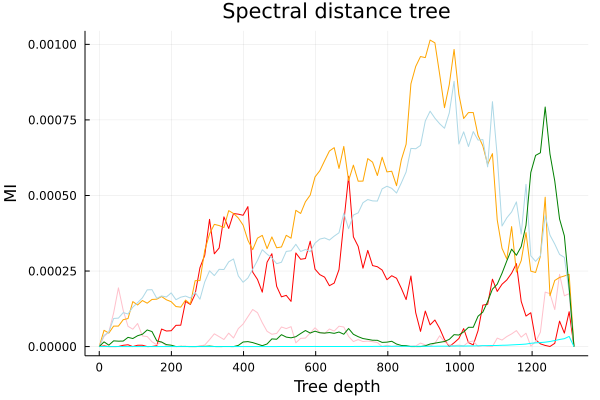

In [32]:
plot(title="Spectral distance tree", ylabel="MI", xlabel="Tree depth", legend=:none)
minmax = extrema(mapinternalnodes(network_distance, spi_tree, spi_tree))
cuts = range(0, minmax[2], length=NCUTS)

for (tlab, tcol) in zip(string.(taxaranklabels), taxarankcolors)
    df = filter(:taxaID=> ==(tlab), tstatdf)
    @df df plot!(cuts, :MI, label=tlab, c=tcol, lw=1)
end
plot!()

In [33]:
savefig(joinpath(pdir, "SubsetUP7047_nonmissingtaxonomy_rawMI.pdf"))

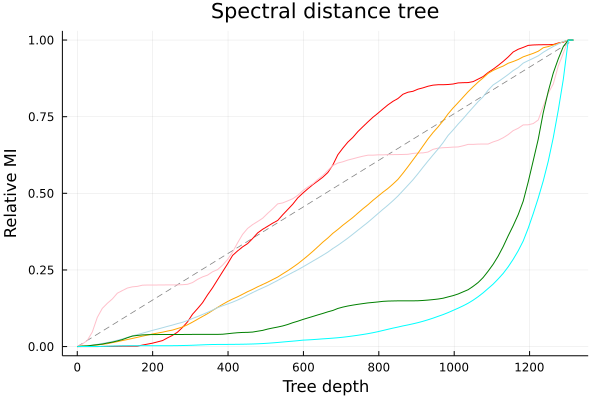

In [34]:
plot(title="Spectral distance tree", ylabel="Relative MI", xlabel="Tree depth", legend=:none)
minmax = extrema(mapinternalnodes(network_distance, spi_tree, spi_tree))
cuts = range(0, minmax[2], length=NCUTS)

plot!([0., last(cuts)], [0., 1.], lw=.75, linestyle=:dash, c=:grey, label="Uniform")
for (tlab, tcol) in zip(string.(taxaranklabels), taxarankcolors)
    df = filter(:taxaID=> ==(tlab), tstatdf)
    @df df plot!(cuts, scaledcumsum(:MI), label=tlab, c=tcol, lw=1)
end
plot!()

In [35]:
savefig(joinpath(pdir, "SubsetUP7047_nonmissingtaxonomy_relMI.pdf"))

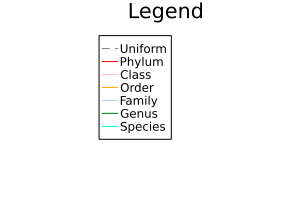

In [36]:
plot(title="Legend", framestyle=:none, size=(300,200), legend=:top)
plot!([0], lw=.75, linestyle=:dash, c=:grey, label="Uniform")
plot!([0 0 0 0 0 0], label=permutedims(string.(taxaranklabels)), c=taxarankcolors, lw=1)


In [37]:
savefig(joinpath(pdir, "SubsetUP7047_nonmissingtaxonomy_legend.pdf"))